<a href="https://colab.research.google.com/github/SoniHarsh1/Dynamic-Allocation-Strategies-for-Multi-Agent-Target-Defense-Differential-Games/blob/main/1v3v4_using_PuLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[[0 0 1 0]
 [0 0 0 1]
 [0 1 0 0]]
time - 0
[[0 0 1 0]
 [1 0 0 0]
 [0 1 0 0]]
time - 0.07019999999999996
Attacker 2 Captured by Defender 1
[[0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]]
time - 0.1482000000000022
Attacker 3 Captured by Defender 1
[[1 0 0 0]
 [0 0 0 1]
 [0 0 0 0]]
time - 0.15140000000000228
Attacker 1 Captured by Defender 1
[[0 0 0 1]
 [0 0 0 0]
 [0 0 0 0]]
time - 0.1624000000000026
Attacker 4 Captured by Defender 1


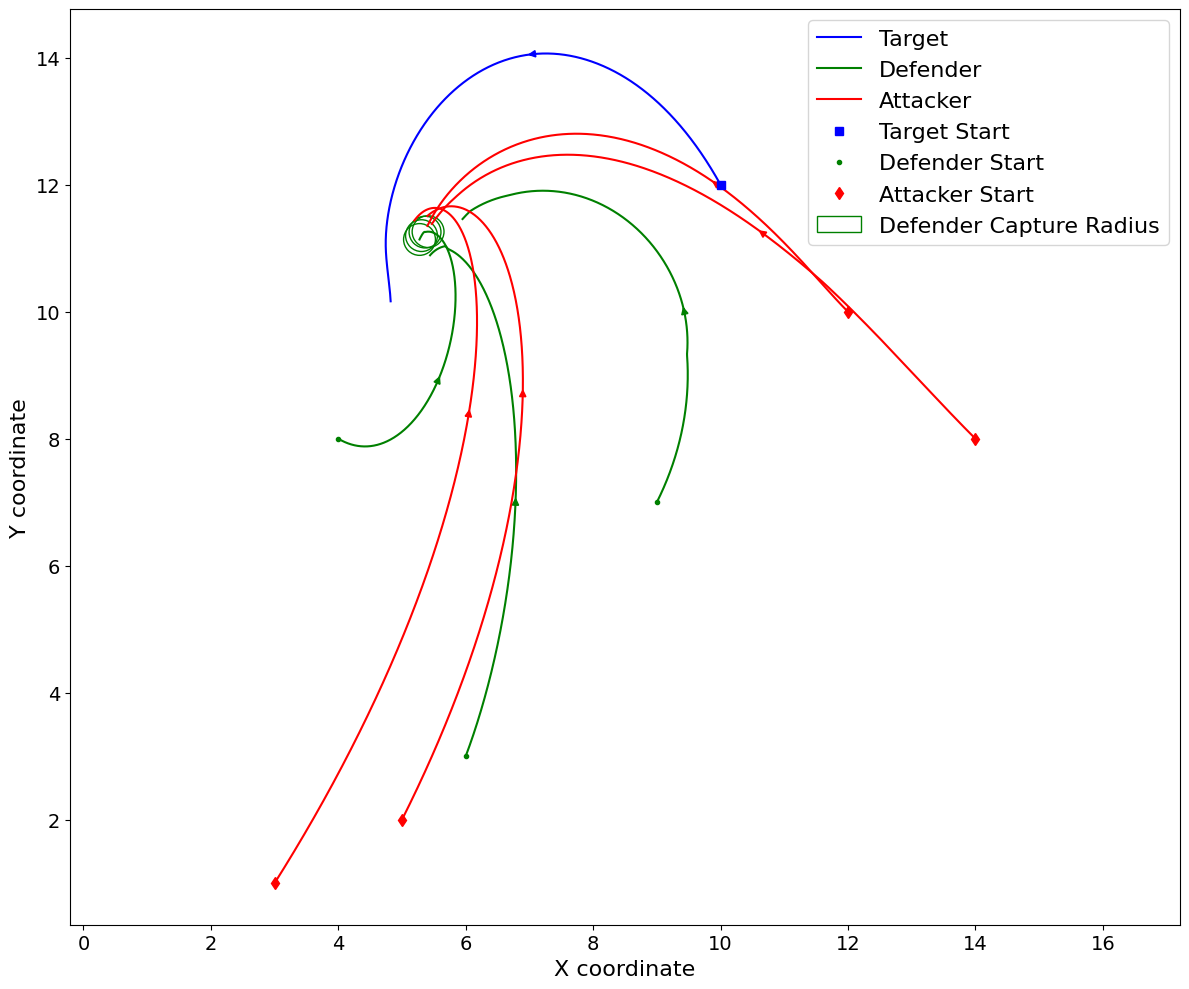

Game Over: All Attackers captured by Defenders
Game duration: 0.17 time units


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, inv
!pip install pulp
from pulp import *

import matplotlib.animation as animation
from matplotlib.patches import Circle
from IPython.display import HTML
import os

# Initial location of the players (1 target, 3 defenders, 4 attackers)
#X_0 = np.array([9, 10, 0, 10, 10, 10, 5, 5, 0, 0, 1, 0, 0, 1, 5, 0])     # all attackers are captured
#X_0 = np.array([9, 10, 0, 10, 8, 12, 5, 7, 6, 6, 1, 0, 0, 1, 5, 0])      # all attackers are captured sigma 0.1
#X_0 = np.array([0, 9, 0, 10, 8, 12, 5, 7, 6, 6, 1, 0, 0, 1, 5, 0])       # all attackers are captured
#X_0 = np.array([5, 5, 0, 5, 8, 5, 5, 0, 2, 0, 7, 0, 0, 4, 7, 3])           #Target Captured Sgma 0.25
#X_0 = np.array([5, 5, 3, 5, 5, 5, 7, 5, 6, 5, 8, 5, 4, 5, 2, 5])          #All Attackes Captured!!!!
#X_0 = np.array([5, 5, 2, 1, 8, 3, 3, 9, 1, 4, 6, 7, 7, 1, 4, 6])           #Target Captured S1
#X_0 = np.array([5, 5, 2, 1, 8, 3, 3, 6, 1, 4, 6, 7, 7, 2, 4, 6])           #All Attackers Captured
X_0 = np.array([10, 12, 4, 8, 9, 7, 6, 3, 14, 8, 5, 2, 3, 1, 12, 10])       #All Attackers Captured - Working S2
#X_0 = np.array([1, 10, 1, 7, 3, 7, 5, 9, 2, 1, 4, 2, 6, 2, 5, 3])


# Initialization parameters
O_16 = np.zeros((16, 16))
O = np.zeros((2, 2))
I = np.eye(16)

B_t = np.vstack((np.eye(2), np.zeros((14, 2))))
B_d1 = np.vstack((np.zeros((2, 2)), np.eye(2), np.zeros((12, 2))))
B_d2 = np.vstack((np.zeros((4, 2)), np.eye(2), np.zeros((10, 2))))
B_d3 = np.vstack((np.zeros((6, 2)), np.eye(2), np.zeros((8, 2))))
B_a1 = np.vstack((np.zeros((8, 2)), np.eye(2), np.zeros((6, 2))))
B_a2 = np.vstack((np.zeros((10, 2)), np.eye(2), np.zeros((4, 2))))
B_a3 = np.vstack((np.zeros((12, 2)), np.eye(2), np.zeros((2, 2))))
B_a4 = np.vstack((np.zeros((14, 2)), np.eye(2)))

rt, rd1, rd2, rd3, ra1, ra2, ra3, ra4 = 30, 40, 40, 40, 20, 20, 20, 20
R_t = rt * np.eye(2)
R_d1 = rd1 * np.eye(2)
R_d2 = rd2 * np.eye(2)
R_d3 = rd3 * np.eye(2)
R_a1 = ra1 * np.eye(2)
R_a2 = ra2 * np.eye(2)
R_a3 = ra3 * np.eye(2)
R_a4 = ra4 * np.eye(2)

Q_a1d1T = Q_a2d2T = Q_a3d3T = Q_a4d1T = Q_a4d2T = Q_a4d3T = Q_a1tT = Q_a2tT = Q_a3tT = Q_a4tT = Q_d1tT = Q_d2tT = Q_d3tT = np.eye(2)

S_t = B_t @ inv(R_t) @ B_t.T
S_d1 = B_d1 @ inv(R_d1) @ B_d1.T
S_d2 = B_d2 @ inv(R_d2) @ B_d2.T
S_d3 = B_d3 @ inv(R_d3) @ B_d3.T
S_a1 = B_a1 @ inv(R_a1) @ B_a1.T
S_a2 = B_a2 @ inv(R_a2) @ B_a2.T
S_a3 = B_a3 @ inv(R_a3) @ B_a3.T
S_a4 = B_a4 @ inv(R_a4) @ B_a4.T

# Initialize variables to store capture information
captured_by_attacker = False
capturing_attacker = None
all_attackers_captured = False
capturing_agent_index = None
captured_attackers = [False, False, False, False]

def euclidean_distance(pos1, pos2):
    return np.linalg.norm(np.array(pos1) - np.array(pos2))

# Get the assignment using PuLP
def get_assignment(defenders, attackers, captured_attackers):
    num_defenders = len(defenders)
    num_attackers = len(attackers)
    active_attackers = sum(1 for a in captured_attackers if not a)

    # Create the LP problem
    prob = LpProblem("Defender-Attacker_Assignment", LpMinimize)

    # Create decision variables only for non-captured attackers
    choices = LpVariable.dicts("Choice",
                               ((i, j) for i in range(num_defenders) for j in range(num_attackers) if not captured_attackers[j]),
                               cat='Binary')

    # Objective function
    prob += lpSum([euclidean_distance(defenders[i], attackers[j]) * choices[(i, j)]
                   for i in range(num_defenders) for j in range(num_attackers) if not captured_attackers[j]])

    # Constraints
    # Each active attacker is assigned to at most one defender
    for j in range(num_attackers):
        if not captured_attackers[j]:
            prob += lpSum([choices[(i, j)] for i in range(num_defenders)]) <= 1

    # Each defender is assigned to at most one attacker
    for i in range(num_defenders):
        prob += lpSum([choices[(i, j)] for j in range(num_attackers) if not captured_attackers[j]]) <= 1

    # Total assignments should be the minimum of active attackers and defenders
    prob += lpSum([choices[(i, j)] for i in range(num_defenders)
                   for j in range(num_attackers) if not captured_attackers[j]]) == min(num_defenders, active_attackers)

    # Solve the problem
    prob.solve()

    # Create the assignment matrix (maintaining original dimensions)
    assignment_matrix = np.zeros((num_defenders, num_attackers), dtype=int)
    for i in range(num_defenders):
        for j in range(num_attackers):
            if not captured_attackers[j] and (i, j) in choices:
                if choices[(i, j)].value() == 1:
                    assignment_matrix[i][j] = 1

    return assignment_matrix

# Step size and T selection
T = 0.02
tk = 0
step1 = 100
deltaT = T / step1
j = 0
sigmaa = 0.25
sigmad = 0.25
sigmat = 0
tflag = 0
time = [tk]
count = 0
X_t = []

check = np.zeros((3, 4), dtype=int)

while tflag == 0:
    defenders = [X_0[2:4], X_0[4:6], X_0[6:8]]
    attackers = [X_0[8:10], X_0[10:12], X_0[12:14], X_0[14:16]]

    # Get the assignment matrix
    Asgn = get_assignment(defenders, attackers, captured_attackers)

    if(check != Asgn).any():
        print(Asgn)
        check = Asgn
        print("time -", time[-1])

    Q_t = np.block([
        [Q_d1tT+Q_d2tT+Q_d3tT-Q_a1tT-Q_a2tT-Q_a3tT-Q_a4tT, -Q_d1tT, -Q_d2tT, -Q_d3tT, Q_a1tT, Q_a2tT, Q_a3tT, Q_a4tT],
        [-Q_d1tT, Q_d1tT, O, O, O, O, O, O],
        [-Q_d2tT, O, Q_d2tT, O, O, O, O, O],
        [-Q_d3tT, O, O, Q_d3tT, O, O, O, O],
        [Q_a1tT, O, O, O, -Q_a1tT, O, O, O],
        [Q_a2tT, O, O, O, O, -Q_a2tT, O, O],
        [Q_a3tT, O, O, O, O, O, -Q_a3tT, O],
        [Q_a4tT, O, O, O, O, O, O, -Q_a4tT]
    ])

    Q_d1 = np.block([
        [Q_d1tT, -Q_d1tT, O, O, O, O, O, O],
        [-Q_d1tT, Q_d1tT+Asgn[0][0]*Q_a1d1T+Asgn[0][1]*Q_a2d2T+Asgn[0][2]*Q_a3d3T+Asgn[0][3]*Q_a4d1T, O, O, -Asgn[0][0]*Q_a1d1T, -Asgn[0][1]*Q_a2d2T, -Asgn[0][2]*Q_a3d3T, -Asgn[0][3]*Q_a4d1T],
        [O, O, Asgn[1][0]*Q_a1d1T+Asgn[1][1]*Q_a2d2T+Asgn[1][2]*Q_a3d3T+Asgn[1][3]*Q_a4d2T, O, -Asgn[1][0]*Q_a1d1T, -Asgn[1][1]*Q_a2d2T, -Asgn[1][2]*Q_a3d3T, -Asgn[1][3]*Q_a4d2T],
        [O, O, O, Asgn[2][0]*Q_a1d1T+Asgn[2][1]*Q_a2d2T+Asgn[2][2]*Q_a3d3T+Asgn[2][3]*Q_a4d3T, -Asgn[2][0]*Q_a1d1T, -Asgn[2][1]*Q_a2d2T, -Asgn[2][2]*Q_a3d3T, -Asgn[2][3]*Q_a4d3T],
        [O, -Asgn[0][0]*Q_a1d1T, -Asgn[1][0]*Q_a1d1T, -Asgn[2][0]*Q_a1d1T, Asgn[0][0]*Q_a1d1T+Asgn[1][0]*Q_a1d1T+Asgn[2][0]*Q_a1d1T, O, O, O],
        [O, -Asgn[0][1]*Q_a2d2T, -Asgn[1][1]*Q_a2d2T, -Asgn[2][1]*Q_a2d2T, O, Asgn[0][1]*Q_a2d2T+Asgn[1][1]*Q_a2d2T+Asgn[2][1]*Q_a2d2T, O, O],
        [O, -Asgn[0][2]*Q_a3d3T, -Asgn[1][2]*Q_a3d3T, -Asgn[2][2]*Q_a3d3T, O, O, Asgn[0][2]*Q_a3d3T+Asgn[1][2]*Q_a3d3T+Asgn[2][2]*Q_a3d3T, O],
        [O, -Asgn[0][3]*Q_a4d1T, -Asgn[1][3]*Q_a4d2T, -Asgn[2][3]*Q_a4d3T, O, O, O, Asgn[0][3]*Q_a4d1T+Asgn[1][3]*Q_a4d2T+Asgn[2][3]*Q_a4d3T]
    ])

    Q_d2 = np.block([
        [Q_d2tT, O, -Q_d2tT, O, O, O, O, O],
        [O, Asgn[0][0]*Q_a1d1T+Asgn[0][1]*Q_a2d2T+Asgn[0][2]*Q_a3d3T+Asgn[0][3]*Q_a4d1T, O, O, -Asgn[0][0]*Q_a1d1T, -Asgn[0][1]*Q_a2d2T, -Asgn[0][2]*Q_a3d3T, -Asgn[0][3]*Q_a4d1T],
        [-Q_d2tT, O, Q_d2tT+Asgn[1][0]*Q_a1d1T+Asgn[1][1]*Q_a2d2T+Asgn[1][2]*Q_a3d3T+Asgn[1][3]*Q_a4d2T, O, -Asgn[1][0]*Q_a1d1T, -Asgn[1][1]*Q_a2d2T, -Asgn[1][2]*Q_a3d3T, -Asgn[1][3]*Q_a4d2T],
        [O, O, O, Asgn[2][0]*Q_a1d1T+Asgn[2][1]*Q_a2d2T+Asgn[2][2]*Q_a3d3T+Asgn[2][3]*Q_a4d3T, -Asgn[2][0]*Q_a1d1T, -Asgn[2][1]*Q_a2d2T, -Asgn[2][2]*Q_a3d3T, -Asgn[2][3]*Q_a4d3T],
        [O, -Asgn[0][0]*Q_a1d1T, -Asgn[1][0]*Q_a1d1T, -Asgn[2][0]*Q_a1d1T, Asgn[0][0]*Q_a1d1T+Asgn[1][0]*Q_a1d1T+Asgn[2][0]*Q_a1d1T, O, O, O],
        [O, -Asgn[0][1]*Q_a2d2T, -Asgn[1][1]*Q_a2d2T, -Asgn[2][1]*Q_a2d2T, O, Asgn[0][1]*Q_a2d2T+Asgn[1][1]*Q_a2d2T+Asgn[2][1]*Q_a2d2T, O, O],
        [O, -Asgn[0][2]*Q_a3d3T, -Asgn[1][2]*Q_a3d3T, -Asgn[2][2]*Q_a3d3T, O, O, Asgn[0][2]*Q_a3d3T+Asgn[1][2]*Q_a3d3T+Asgn[2][2]*Q_a3d3T, O],
        [O, -Asgn[0][3]*Q_a4d1T, -Asgn[1][3]*Q_a4d2T, -Asgn[2][3]*Q_a4d3T, O, O, O, Asgn[0][3]*Q_a4d1T+Asgn[1][3]*Q_a4d2T+Asgn[2][3]*Q_a4d3T]
    ])

    Q_d3 = np.block([
        [Q_d3tT, O, O, -Q_d3tT, O, O, O, O],
        [O, Asgn[0][0]*Q_a1d1T+Asgn[0][1]*Q_a2d2T+Asgn[0][2]*Q_a3d3T+Asgn[0][3]*Q_a4d1T, O, O, -Asgn[0][0]*Q_a1d1T, -Asgn[0][1]*Q_a2d2T, -Asgn[0][2]*Q_a3d3T, -Asgn[0][3]*Q_a4d1T],
        [O, O, Asgn[1][0]*Q_a1d1T+Asgn[1][1]*Q_a2d2T+Asgn[1][2]*Q_a3d3T+Asgn[1][3]*Q_a4d2T, O, -Asgn[1][0]*Q_a1d1T, -Asgn[1][1]*Q_a2d2T, -Asgn[1][2]*Q_a3d3T, -Asgn[1][3]*Q_a4d2T],
        [-Q_d3tT, O, O, Q_d3tT+Asgn[2][0]*Q_a1d1T+Asgn[2][1]*Q_a2d2T+Asgn[2][2]*Q_a3d3T+Asgn[2][3]*Q_a4d3T, -Asgn[2][0]*Q_a1d1T, -Asgn[2][1]*Q_a2d2T, -Asgn[2][2]*Q_a3d3T, -Asgn[2][3]*Q_a4d3T],
        [O, -Asgn[0][0]*Q_a1d1T, -Asgn[1][0]*Q_a1d1T, -Asgn[2][0]*Q_a1d1T, Asgn[0][0]*Q_a1d1T+Asgn[1][0]*Q_a1d1T+Asgn[2][0]*Q_a1d1T, O, O, O],
        [O, -Asgn[0][1]*Q_a2d2T, -Asgn[1][1]*Q_a2d2T, -Asgn[2][1]*Q_a2d2T, O, Asgn[0][1]*Q_a2d2T+Asgn[1][1]*Q_a2d2T+Asgn[2][1]*Q_a2d2T, O, O],
        [O, -Asgn[0][2]*Q_a3d3T, -Asgn[1][2]*Q_a3d3T, -Asgn[2][2]*Q_a3d3T, O, O, Asgn[0][2]*Q_a3d3T+Asgn[1][2]*Q_a3d3T+Asgn[2][2]*Q_a3d3T, O],
        [O, -Asgn[0][3]*Q_a4d1T, -Asgn[1][3]*Q_a4d2T, -Asgn[2][3]*Q_a4d3T, O, O, O, Asgn[0][3]*Q_a4d1T+Asgn[1][3]*Q_a4d2T+Asgn[2][3]*Q_a4d3T]
    ])

    Q_a1 = np.block([
        [Q_a1tT, O, O, O, -Q_a1tT, O, O, O],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O],
        [-Q_a1tT, O, O, O, Q_a1tT, O, O, O],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O]
    ])

    Q_a2 = np.block([
        [Q_a2tT, O, O, O, O, -Q_a2tT, O, O],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O],
        [-Q_a2tT, O, O, O, O, Q_a2tT, O, O],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O]
    ])

    Q_a3 = np.block([
        [Q_a3tT, O, O, O, O, O, -Q_a3tT, O],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O],
        [-Q_a3tT, O, O, O, O, O, Q_a3tT, O],
        [O, O, O, O, O, O, O, O]
    ])

    Q_a4 = np.block([
        [Q_a4tT, O, O, O, O, O, O, -Q_a4tT],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O],
        [O, O, O, O, O, O, O, O],
        [-Q_a4tT, O, O, O, O, O, O, Q_a4tT]
    ])

    M = np.block([
        [O_16, -S_t, -S_d1, -S_d2, -S_d3, -S_a1, -S_a2, -S_a3, -S_a4],
        [-Q_a1, O_16, O_16, O_16, O_16, O_16, O_16, O_16, O_16],
        [-Q_a2, O_16, O_16, O_16, O_16, O_16, O_16, O_16, O_16],
        [-Q_a3, O_16, O_16, O_16, O_16, O_16, O_16, O_16, O_16],
        [-Q_a4, O_16, O_16, O_16, O_16, O_16, O_16, O_16, O_16],
        [-Q_d1, O_16, O_16, O_16, O_16, O_16, O_16, O_16, O_16],
        [-Q_d2, O_16, O_16, O_16, O_16, O_16, O_16, O_16, O_16],
        [-Q_d3, O_16, O_16, O_16, O_16, O_16, O_16, O_16, O_16],
        [-Q_t, O_16, O_16, O_16, O_16, O_16, O_16, O_16, O_16]
    ])

    Q = np.vstack((I, Q_t, Q_d1, Q_d2, Q_d3, Q_a1, Q_a2, Q_a3, Q_a4))
    H_T = np.hstack((I, O_16, O_16, O_16, O_16, O_16, O_16, O_16, O_16)) @ expm(-M * (tk + T)) @ Q
    Y = expm(-M * T) @ Q @ inv(H_T) @ X_0

    # Update positions only for active agents
    new_X_0 = X_0.copy().astype(float)
    new_X_0[:8] = Y[:8]  # Update target and defenders
    for i in range(4):
        if not captured_attackers[i]:
            new_X_0[8+2*i:10+2*i] = Y[8+2*i:10+2*i]  # Update active attackers
    X_0 = new_X_0

    X_t.append(X_0)

    # Check for captures
    for i in range(4):
        if np.linalg.norm(Y[:2] - Y[8+2*i:10+2*i]) <= sigmaa and not captured_attackers[i]:
            print(f'Target Captured by Attacker {i+1}')
            captured_by_attacker = True
            capturing_agent_index = i
            capturing_attacker = i
            tflag = 1
            break

    if not captured_by_attacker:
        for i in range(3):
            for j in range(4):
                if np.linalg.norm(Y[2+2*i:4+2*i] - Y[8+2*j:10+2*j]) <= sigmad and not captured_attackers[j]:
                    print(f'Attacker {j+1} Captured by Defender {i+1}')
                    captured_attackers[j] = True
                    capturing_agent_index = i
                    break
            if all(captured_attackers):
                all_attackers_captured = True
                tflag = 1
                break
    j += 1
    tk += deltaT
    count += 1
    time.append(tk)

X_t = np.array(X_t).T

# Plotting
plt.figure(figsize=(12, 10))
plt.plot(X_t[0], X_t[1], color='b', linewidth=1.5, label='Target')
plt.plot(X_t[2], X_t[3], color='g', linewidth=1.5, label='Defender')
plt.plot(X_t[4], X_t[5], color='g', linewidth=1.5)
plt.plot(X_t[6], X_t[7], color='g', linewidth=1.5)
plt.plot(X_t[8], X_t[9], color='r', linewidth=1.5, label='Attacker')
plt.plot(X_t[10], X_t[11], color='r', linewidth=1.5)
plt.plot(X_t[12], X_t[13], color='r', linewidth=1.5)
plt.plot(X_t[14], X_t[15], color='r', linewidth=1.5)

# Add markers to the initial positions
plt.plot(X_t[0, 0], X_t[1, 0], 's', markersize=6, color='b', label='Target Start')
plt.plot(X_t[2, 0], X_t[3, 0], '.', markersize=6, color='g', label='Defender Start')
plt.plot(X_t[4, 0], X_t[5, 0], '.', markersize=6, color='g')
plt.plot(X_t[6, 0], X_t[7, 0], '.', markersize=6, color='g')
plt.plot(X_t[8, 0], X_t[9, 0], 'd', markersize=6, color='r', label='Attacker Start')
plt.plot(X_t[10, 0], X_t[11, 0], 'd', markersize=6, color='r')
plt.plot(X_t[12, 0], X_t[13, 0], 'd', markersize=6, color='r')
plt.plot(X_t[14, 0], X_t[15, 0], 'd', markersize=6, color='r')

# Add arrows to show direction of movement
mid_point = len(X_t[0]) // 2
arrow_length = 0.1
arrow_width = 0.1
arrow_color = 'black'

# Function to add arrow
def add_arrow(x, y, dx, dy, color):
    plt.arrow(x, y, dx, dy, head_width=arrow_width, head_length=arrow_length,
              fc=color, ec=color, length_includes_head=True)

# Add arrows for all entities
for i in range(0, 16, 2):
    add_arrow(X_t[i, mid_point], X_t[i+1, mid_point],
              X_t[i, mid_point+1] - X_t[i, mid_point],
              X_t[i+1, mid_point+1] - X_t[i+1, mid_point],
              'blue' if i == 0 else ('green' if i < 8 else 'red'))

# Add capture zones
if captured_by_attacker:
    circle = plt.Circle((X_t[8+2*capturing_agent_index, -1], X_t[9+2*capturing_agent_index, -1]),
                        sigmaa, fill=False, edgecolor='r', label='Attacker Capture Radius')
    plt.gca().add_artist(circle)
if any(captured_attackers):
    capture_radius_added = False
    for i in range(3):  # For each defender
        for j in range(4):  # For each attacker
            if captured_attackers[j]:
                # Find the time step where the capture occurred
                capture_step = next((step for step in range(len(X_t[0]))
                                     if np.linalg.norm(X_t[2+2*i:4+2*i, step] - X_t[8+2*j:10+2*j, step]) <= sigmad), None)
                if capture_step is not None:
                    circle = plt.Circle((X_t[2+2*i, capture_step], X_t[3+2*i, capture_step]),
                                        sigmad, fill=False, edgecolor='g',
                                        label='Defender Capture Radius' if not capture_radius_added else "")
                    plt.gca().add_artist(circle)
                    capture_radius_added = True

plt.axis('equal')
plt.legend(fontsize="16")
plt.xlabel('X coordinate', fontsize="16")
plt.ylabel('Y coordinate', fontsize="16")
plt.tick_params(axis='both', which='major', labelsize="14")
#plt.title('TAD Game: 1 Target, 3 Defenders, 4 Attackers')
plt.tight_layout()
#plt.savefig("1v3v4S2pdf.pdf", format='pdf', bbox_inches='tight')
plt.show()

# Print game result
if captured_by_attacker:
    print(f"Game Over: Target captured by Attacker {capturing_agent_index + 1}")
elif all_attackers_captured:
    print("Game Over: All Attackers captured by Defenders")
else:
    print("Game ended without capture")

print(f"Game duration: {time[-1]:.2f} time units")



def create_pursuit_animation(X_t, captured_attackers, target_captured, capturing_attacker,
                           sigmaa=0.25, sigmad=0.25, interval=50, end_pause=1000):
    # Setup the figure and axis
    fig, ax = plt.subplots(figsize=(12, 10))

    # Initialize lines for paths
    target_line, = ax.plot([], [], 'b-', linewidth=1.5, label='Target')
    defender_lines = [ax.plot([], [], 'g-', linewidth=1.5, label='Defender' if i == 0 else None)[0]
                     for i in range(3)]
    attacker_lines = [ax.plot([], [], 'r-', linewidth=1.5, label='Attacker' if i == 0 else None)[0]
                     for i in range(4)]  # Changed to 4 attackers

    # Initialize markers for current positions
    target_pos, = ax.plot([], [], 'bs', markersize=8, label='Target Position')
    defender_pos = [ax.plot([], [], 'go', markersize=8, label='Defender Position' if i == 0 else None)[0]
                   for i in range(3)]
    attacker_pos = [ax.plot([], [], 'rd', markersize=8, label='Attacker Position' if i == 0 else None)[0]
                   for i in range(4)]  # Changed to 4 attackers

    # Find capture frames and locations for defenders catching attackers
    defender_capture_info = []
    for i in range(4):  # Changed to 4 attackers
        if captured_attackers[i]:
            capture_frame = None
            capture_location = None
            for frame in range(len(X_t[0])):
                for j in range(3):  # Check against each defender
                    dist = np.sqrt((X_t[2+2*j, frame] - X_t[8+2*i, frame])**2 +
                                 (X_t[3+2*j, frame] - X_t[9+2*i, frame])**2)
                    if dist <= sigmad:
                        capture_frame = frame
                        capture_location = (X_t[2+2*j, frame], X_t[3+2*j, frame])
                        break
                if capture_frame is not None:
                    break
            defender_capture_info.append((capture_frame, capture_location))
        else:
            defender_capture_info.append((None, None))

    # Find capture frame and location for attacker catching target
    target_capture_info = (None, None)
    if target_captured and capturing_attacker is not None:
        for frame in range(len(X_t[0])):
            dist = np.sqrt((X_t[8+2*capturing_attacker, frame] - X_t[0, frame])**2 +
                         (X_t[9+2*capturing_attacker, frame] - X_t[1, frame])**2)
            if dist <= sigmaa:
                target_capture_info = (frame, (X_t[8+2*capturing_attacker, frame],
                                             X_t[9+2*capturing_attacker, frame]))
                break

    # Initialize capture radius circles
    defender_circles = [Circle((0, 0), sigmad, fill=False, color='g', visible=False,
                             alpha=0.7, linestyle='-') for _ in range(3)]
    target_capture_circle = Circle((0, 0), sigmaa, fill=False, color='r', visible=False,
                                 alpha=0.7, linestyle='-')

    # Add circles to the plot
    for circle in defender_circles + [target_capture_circle]:
        ax.add_patch(circle)

    # Set axis limits
    margin = 1
    ax.set_xlim(np.min(X_t[::2]) - margin, np.max(X_t[::2]) + margin)
    ax.set_ylim(np.min(X_t[1::2]) - margin, np.max(X_t[1::2]) + margin)

    # Add labels and title
    ax.set_aspect('equal')
    ax.set_xlabel('X coordinate', fontsize=14)
    ax.set_ylabel('Y coordinate', fontsize=14)
    ax.set_title('Multi-Agent Pursuit-Evasion Game', fontsize=16)

    def init():
        # Initialize empty lines and markers
        target_line.set_data([], [])
        target_pos.set_data([], [])
        for line, pos in zip(defender_lines + attacker_lines,
                           defender_pos + attacker_pos):
            line.set_data([], [])
            pos.set_data([], [])
        return [target_line, target_pos] + defender_lines + attacker_lines + \
               defender_pos + attacker_pos + defender_circles + [target_capture_circle]

    def animate(frame):
        # Add pause at the end by repeating the last frame
        actual_frame = min(frame, len(X_t[0]) - 1)

        # Update target path and position
        target_line.set_data(X_t[0, :actual_frame+1], X_t[1, :actual_frame+1])
        target_pos.set_data([X_t[0, actual_frame]], [X_t[1, actual_frame]])

        # Update defender paths and positions
        for i in range(3):
            defender_lines[i].set_data(X_t[2+2*i, :actual_frame+1], X_t[3+2*i, :actual_frame+1])
            defender_pos[i].set_data([X_t[2+2*i, actual_frame]], [X_t[3+2*i, actual_frame]])

        # Update attacker paths and positions
        for i in range(4):  # Changed to 4 attackers
            attacker_lines[i].set_data(X_t[8+2*i, :actual_frame+1], X_t[9+2*i, :actual_frame+1])
            attacker_pos[i].set_data([X_t[8+2*i, actual_frame]], [X_t[9+2*i, actual_frame]])

            # Handle defender capture visualization
            capture_frame, capture_location = defender_capture_info[i]
            if capture_frame is not None and actual_frame >= capture_frame:
                defender_circles[i % 3].center = capture_location  # Use modulo to cycle through defender circles
                defender_circles[i % 3].set_visible(True)

        # Handle target capture visualization
        target_capture_frame, target_capture_location = target_capture_info
        if target_capture_frame is not None and actual_frame >= target_capture_frame:
            target_capture_circle.center = target_capture_location
            target_capture_circle.set_visible(True)

        return [target_line, target_pos] + defender_lines + attacker_lines + \
               defender_pos + attacker_pos + defender_circles + [target_capture_circle]

    # Calculate total frames including pause
    total_frames = len(X_t[0]) + int(end_pause / interval)

    # Create animation
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                 frames=total_frames, interval=interval,
                                 blit=True)

    plt.legend(loc='upper right')
    return anim, fig

def save_animation(anim, fig, filename='pursuit_evasion.gif', fps=30):
    # Remove file if it already exists
    if os.path.exists(filename):
        os.remove(filename)

    # Save the animation
    writer = animation.PillowWriter(fps=fps)
    anim.save(filename, writer=writer)

    # Close the figure to free up memory
    plt.close(fig)

# Create and display the animation
anim, fig = create_pursuit_animation(X_t, captured_attackers,
                                   captured_by_attacker,  # Set this based on your game outcome
                                   capturing_attacker,  # Set this to the index of attacker that caught target
                                   end_pause=1000)  # 1 second pause at the end

# Save the animation
save_animation(anim, fig, 'pursuit_evasion.gif', fps=20)

# Display the animation
plt.show()